# XGB & LGBM

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# EDA
# Loading both Training & Testing Data
train_df=pd.read_csv('Titanic_train.csv')
test_df=pd.read_csv('Titanic_test.csv')
# Inspecting data
train_df.info()
train_df.head()
train_df.describe()
train_df.isnull().sum()
# Droping Unwanted Columns
train_df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
test_df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
# Filling null values with imputation.
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='most_frequent')
train_df[['Age','Embarked']]=imputer.fit_transform(train_df[['Age','Embarked']])
# Changing Data Type.
train_df['Age']=pd.to_numeric(train_df['Age'],errors='coerce')
# Encoding Categorical Testin & Training data
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
train_df['Sex']=enc.fit_transform(train_df['Sex'])
train_df['Embarked']=enc.fit_transform(train_df['Embarked'])
test_df['Sex']=enc.fit_transform(test_df['Sex'])
test_df['Embarked']=enc.fit_transform(test_df['Embarked'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


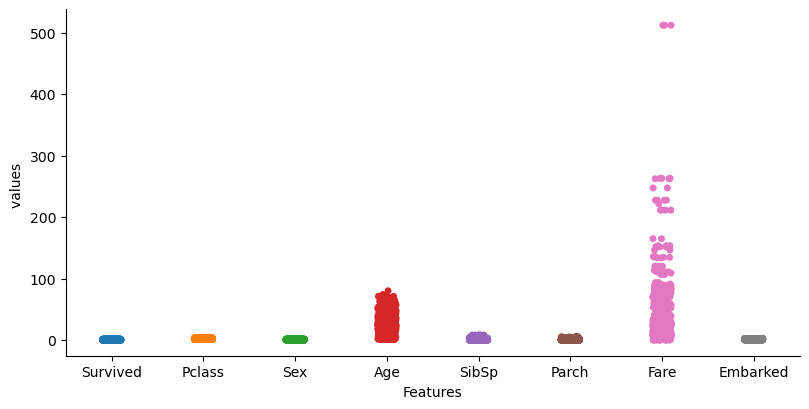

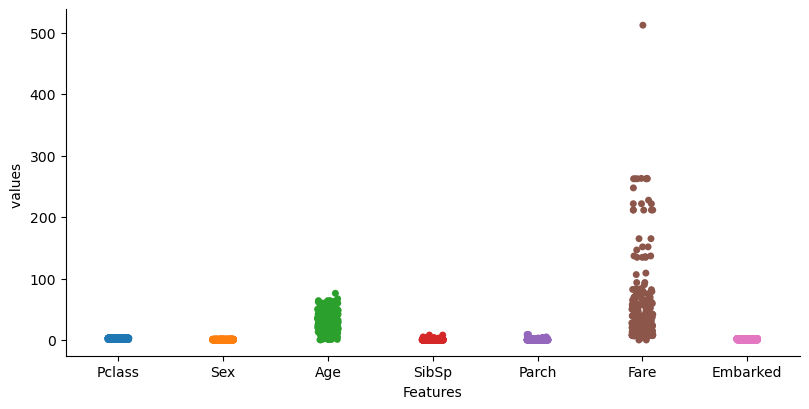

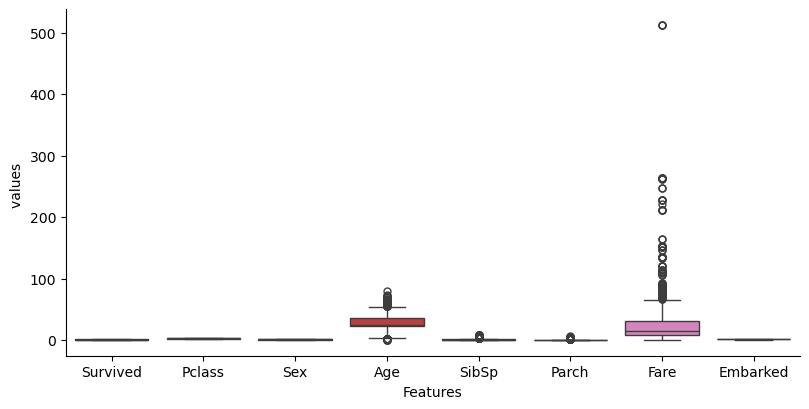

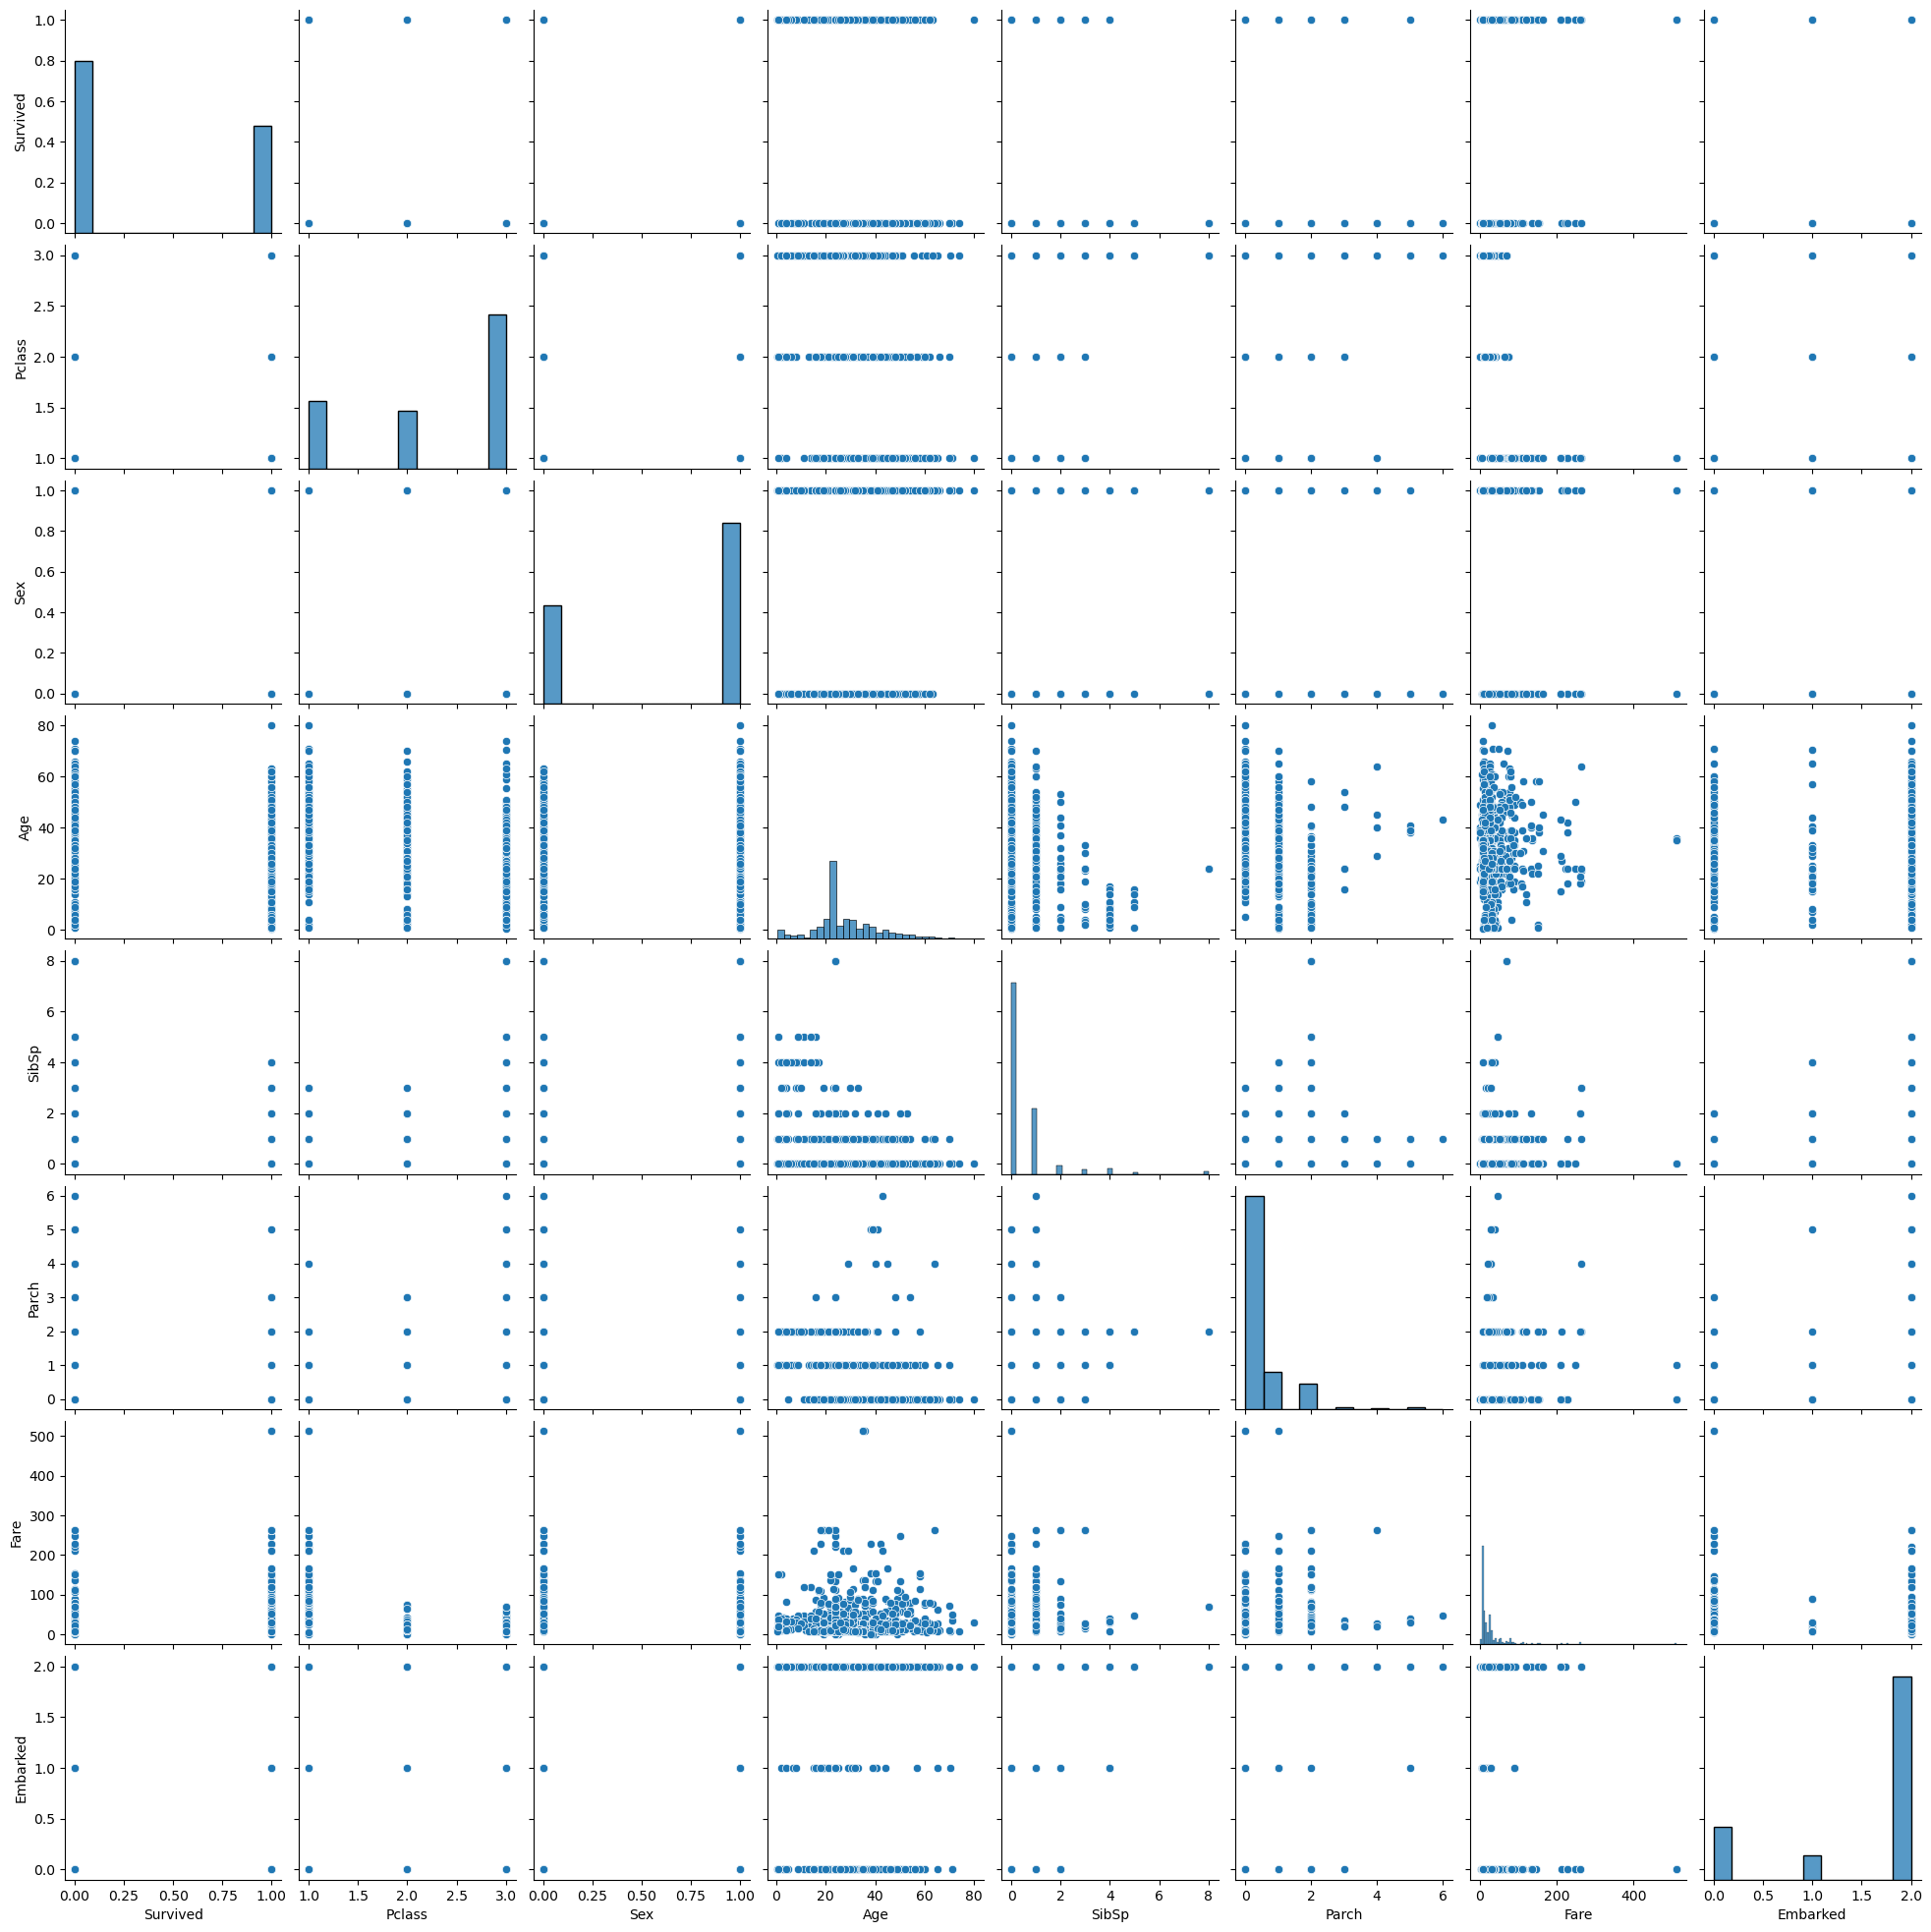

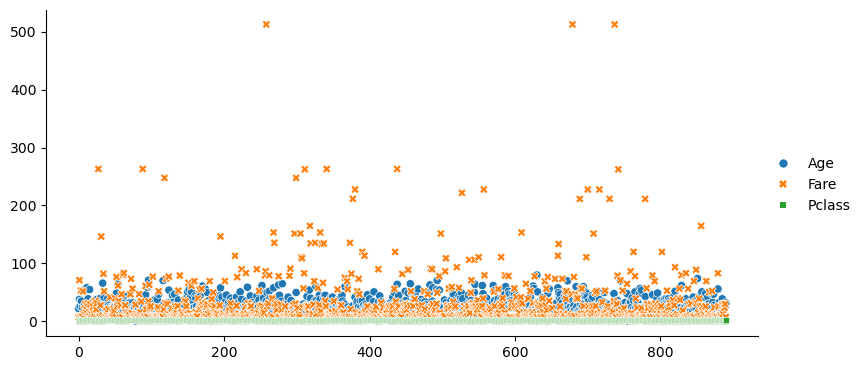

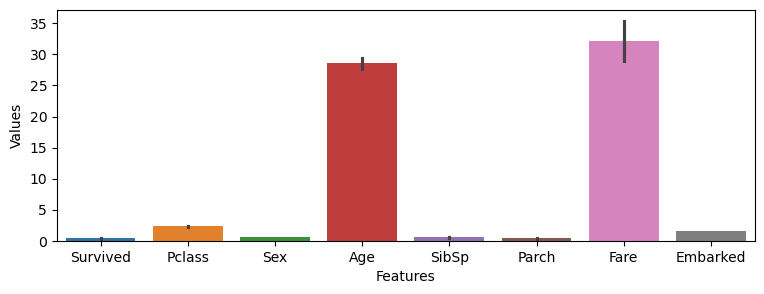

In [4]:
# Visualization of Cleaned Data
# Ploting Swarm plot for outliers inspection
sns.catplot(train_df,height=4,aspect=2)
plt.xlabel('Features')
plt.ylabel('values ')
sns.catplot(test_df,height=4,aspect=2)
plt.xlabel('Features')
plt.ylabel('values ')
plt.show()
# Ploting Box plot for Outliers detection
sns.catplot(train_df,height=4,aspect=2,kind='box')
plt.xlabel('Features')
plt.ylabel('values ')
plt.show()
# Ploting Pairplot for comparing each features and its relation
sns.pairplot(train_df)
plt.show()
# Plotting Scatter plot for below features
sns.relplot(train_df[['Age','Fare','Pclass']],kind='scatter',height=4,aspect=2)
plt.show()
# Ploting Bar Graph 
plt.figure(figsize=(9,3))
sns.barplot(train_df)
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

In [6]:
# Removing Duplicates from DataFrames
train_df[train_df.duplicated()]
train_df.drop_duplicates(inplace=True)
# Removing Outliers with contamination of 10%
from sklearn.ensemble import IsolationForest
isoforest=IsolationForest(n_estimators=50,contamination=0.1,random_state=42)
x=isoforest.fit_predict(train_df)
train_df['anomaly']=x
train_df['anomaly'].value_counts()
# Removing Outliers 
train_df=train_df[train_df['anomaly']==1].drop(columns=['anomaly'])

In [7]:
# Spliting Data in X & y.
X_train=train_df.iloc[:,1:]
y_train=train_df.iloc[:,0]
X_test=test_df
# Importing XGB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
clf=xgb.XGBClassifier()
# Formulating parameters
parameters={
    'n_estimators':[10,30,50,70,90,100],
    'max_depth':[2,4,6,8,10],
    'learning_rate':[0.01,0.05,0.1,0.2,0.5],
    'subsample':[0.5,0.6,0.7,0.9]
}
# Tuning hyperparameters 
gridsearch=GridSearchCV(estimator=clf,param_grid=parameters,scoring='accuracy',n_jobs=-1)
# Training Model
gridsearch.fit(X_train,y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [10, 30, 50, 70, 90, 100],
                         'subsample': [0.5, 0.6, 0.7, 0.9]},
             scoring='accuracy')

In [8]:
# finding Best parameters that fit
gridsearch.best_params_
best_model=gridsearch.best_estimator_
from sklearn.metrics import confusion_matrix,classification_report
# Testing tained data as Yhat.
yhat_train=best_model.predict(X_train)
# Evaluation Metrics formulation
cm=confusion_matrix(y_train,yhat_train)
res_dict=classification_report(y_train,yhat_train,output_dict=True)
xgb_res=pd.DataFrame(res_dict).transpose()
xgb_res

,precision,recall,f1-score,support
0,0.892768,0.949602,0.920308,377.000000
1,0.915929,0.828000,0.869748,250.000000
accuracy,0.901116,0.901116,0.901116,0.901116
macro avg,0.904349,0.888801,0.895028,627.000000
weighted avg,0.902003,0.901116,0.900149,627.000000


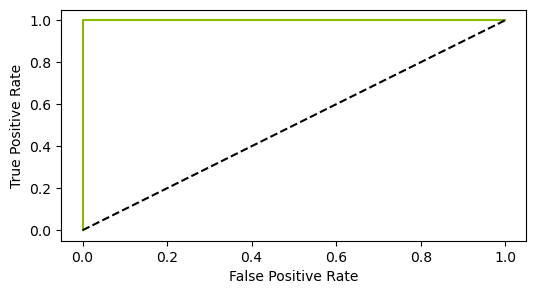

In [9]:
# Testing X_test
y_test=best_model.predict(X_test)
from sklearn.metrics import roc_auc_score,roc_curve
# Ploting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test,best_model.predict_proba (X_test)[:,1])
plt.figure(figsize=(6,3))
plt.plot(fpr, tpr,color='#88BB00')
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [10]:
# Lightgbm 
import lightgbm as lgb
params={
    'learning_rate':[0.01,0.05,0.1,0.5],
    'num_leaves':[8,15,20,26,32],
    'feature_fraction':[0.9,0.8,0.7,0.6,0.5],
    'bagging_fraction':[0.9,0.8,0.7,0.6,0.5] }
# Training Model
lgb_clf=lgb.LGBMClassifier()
lgb_grid=GridSearchCV(estimator=lgb_clf,param_grid=params,scoring='accuracy',n_jobs=-1)
lgb_grid.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 250, number of negative: 377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 627, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398724 -> initscore=-0.410784
[LightGBM] [Info] Star

GridSearchCV(estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'bagging_fraction': [0.9, 0.8, 0.7, 0.6, 0.5],
                         'feature_fraction': [0.9, 0.8, 0.7, 0.6, 0.5],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'num_leaves': [8, 15, 20, 26, 32]},
             scoring='accuracy')

In [11]:
# Selecting best Parameters
lgb_grid.best_params_
lgb_model=lgb_grid.best_estimator_
# Testing model
yhat_train=lgb_model.predict(X_train)
# Evaluating Metrics.
res_dict=classification_report(y_train,yhat_train,output_dict=True)
lgb_result=pd.DataFrame(res_dict,).transpose()
lgb_result

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,precision,recall,f1-score,support
0,0.876238,0.938992,0.906530,377.000000
1,0.896861,0.800000,0.845666,250.000000
accuracy,0.883573,0.883573,0.883573,0.883573
macro avg,0.886549,0.869496,0.876098,627.000000
weighted avg,0.884461,0.883573,0.882262,627.000000


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


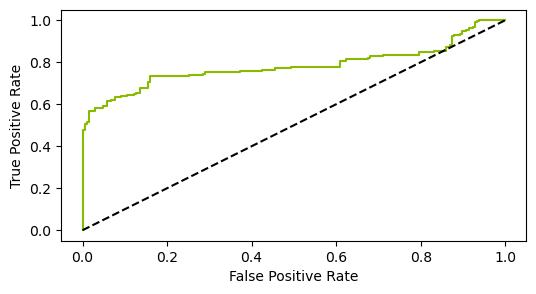

In [12]:
# Predecting Y for X test
y_test=lgb_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,best_model.predict_proba (X_test)[:,1])
# Ploting Roc Curve 
plt.figure(figsize=(6,3))
plt.plot(fpr, tpr,color='#88BB00')
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

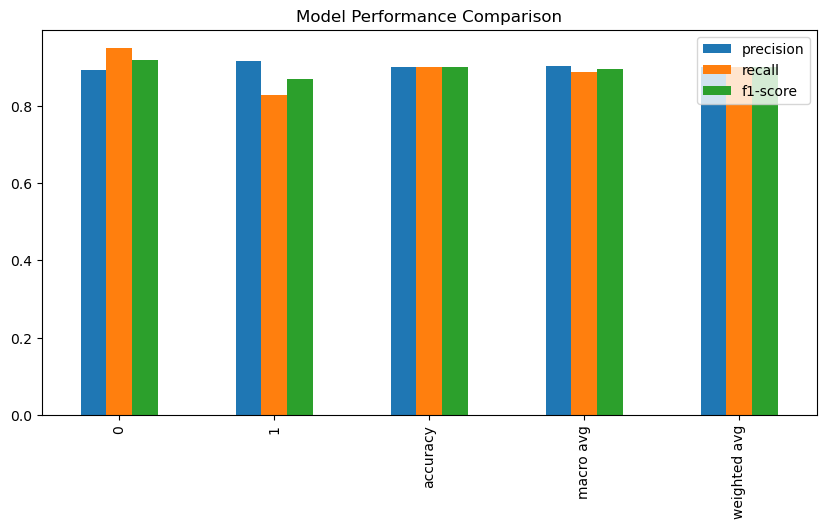

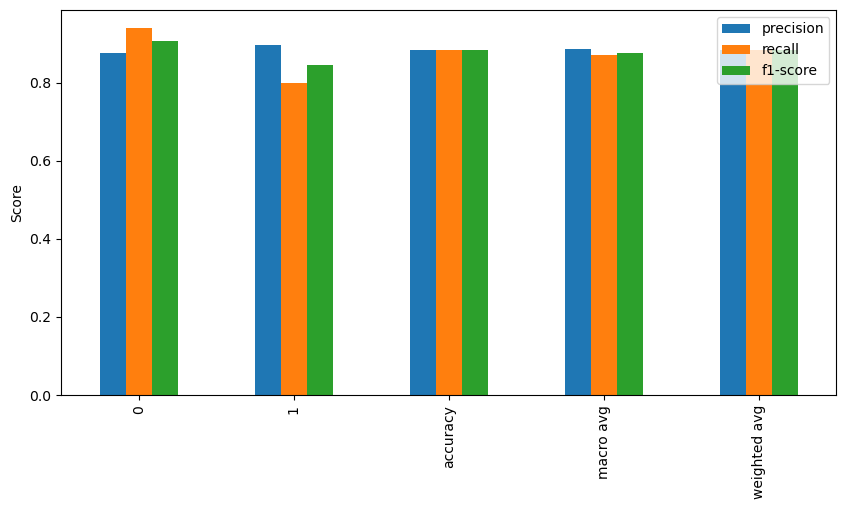

In [14]:
# Comparative Analysis 
xgb_res[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 5))
plt.title("Model Performance Comparison")
lgb_result[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 5))
plt.ylabel("Score")
plt.show()

## Brief Summary

    Age & Fare have good positive corelation and that two are interlinked with each other with survival data.We can assume that most of middle aged people are survived and More expensive class are likely have more chance of survival. Outliers are detected in Fare and age columns where that are reduced and inliers are established by IsolationForest technique with contamination of 10% where most of outliers are reduced.
    Unrelevent data columns are removed and Categorical data is encoded by label encoding technique. After cleaning data Model is formulated,Trained and evaluated by both Xgb model and Lgbm algorithms and those metrics were evaluated,classification Report is prepared. Among them Xgb model and LGBm are performing well competitively with acuuracy around 88 to 90% and F1 score is around 85 to 90 % for both models.For test data metric evaluation ROC Curve is ploted.And also Comparitive visualization is done. Finally I conclude that XGB model is performing well as comparitive to LGBM algorithm. 